<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/period-and-revolution-time-rigid-pendulum-Skates-b/blob/main/period_revolution_time_rigid_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Psuedocode
### *motivation/goal*:
We are finding the period (T) and revolution time (T_rev) of a nonlinear rigid pendulum in two different ways (event and quad)

1. Define constants and set up
- Import libraries
- define constants (g and more?)
- define ODE and integrand

2. Define the functions for period and revolutions
3. Run the solve_ivp and the quad to compute T and T_rev
4. Plot the results

... ngl, I hate this. Def need to review some basic diff eq stuff and maybe some mechanics--> maybe i'd have an easier time with problems that seem simpler to me? i could code those projectile motion problems, and make them themed to be a little more engaging to my brain. Decisions, decisons...

Period (peak-to-peak): 2.0863 s
No revolution detected


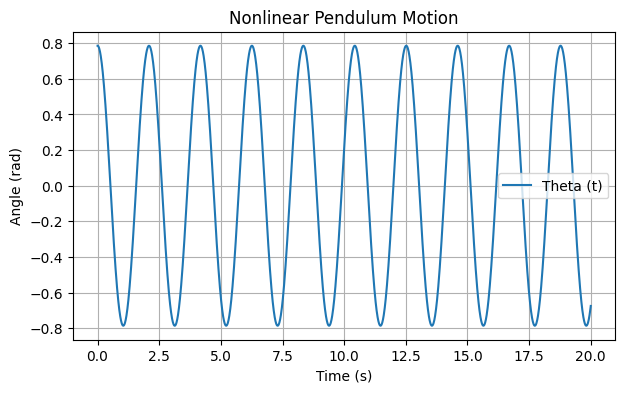

In [3]:
# Installing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

# Physics + Definitions
# --- physical constants ---
I = 1.0
g = 9.81
L = 1.0
w0 = np.sqrt(g/L)
# --- ODE system ---
def pendulum_ode(t, y):
  theta, theta_dot = y
  dtheta_dt = theta_dot
  dtheta_dot_dt = -w0**2 * np.sin(theta)
  return [dtheta_dt, dtheta_dot_dt]
# --- Energy function ---
def energy(theta, theta_dot):
  return 0.5 * I * theta_dot**2 + I * w0**2 * (1 - np.cos(theta))
# --- Event: detect peaks (when velocity crosses 0, going downward)---
def period_event(t, y):
  theta, theta_dot = y
  return theta_dot # event when theta_dot = 0
period_event.direction = -1
period_event.terminal = False

# --- Event: detect full revolution (when theta cross 2pi) ---
def revolution_event(t, y):
  theta, theta_dot = y
  return theta - 2*np.pi
revolution_event.direction = 1
revolution_event.terminal = True

# --- Initial conditions ---
theta0 = np.deg2rad(45)
theta_dot0 = 0.0
y0 = [theta0, theta_dot0]

# --- Time span ---
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# --- SOLVE ---
sol = solve_ivp(pendulum_ode, t_span, y0, t_eval=t_eval, events=[period_event, revolution_event], rtol=1e-9, atol=1e-9)

# --- Extract results ---
t = sol.t
theta = sol.y[0]
theta_dot = sol.y[1]

# --- Find period ---
period_times = sol.t_events[0]
if len(period_times) > 1:
  period = period_times[1] - period_times[0]
else:
  period = None

# --- Find revolution time ---
if len(sol.t_events[1]) > 0:
  revolution_time = sol.t_events[1][0]
else:
  revolution_time = None

# --- Print resuts ---
print(f"Period (peak-to-peak): {period:.4f} s" if period else "No period detected")
print(f"Revolution Time: {revolution_time:.4f} s" if revolution_time else "No revolution detected")

# --- Plot ---
plt.figure(figsize=(7,4))
plt.plot(t, theta, label='Theta (t)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Nonlinear Pendulum Motion')
plt.legend()
plt.grid(True)
plt.show()

Nonlinear period (theta0 = 45 degrees): 2.0863 s
Small-angle period: 2.0061 s
Ratio T/T_small = 1.0400


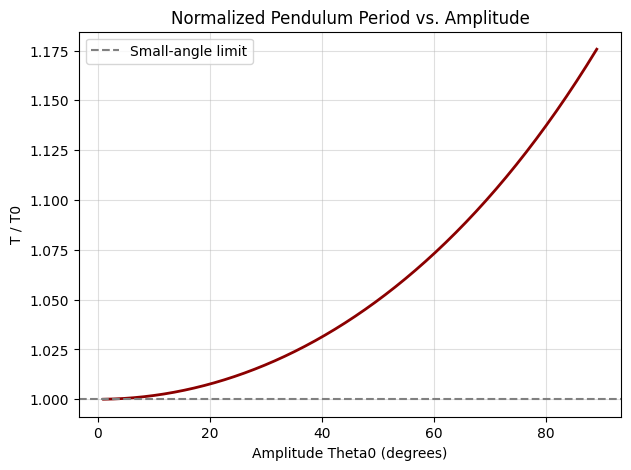

In [6]:
# using quad now.
# define the integrand
def integrand(theta, theta0):
  return 1.0 / np.sqrt(np.cos(theta) - np.cos(theta0))
# --- function to compute the period ---
def nonlinear_period(theta0):
  # perform the integral from 0 to theta0
  integral, _ = quad(integrand, 0, theta0, args=(theta0,))
  T = 4 * np.sqrt(L / (2 * g)) * integral
  return T

# --- Example ---
theta0 = np.deg2rad(45)
T = nonlinear_period(theta0)

# --- Compare to small-angle approximation ---
T_small = 2 * np.pi * np.sqrt(L/g)

print(f"Nonlinear period (theta0 = 45 degrees): {T:.4f} s")
print(f"Small-angle period: {T_small:.4f} s")
print(f"Ratio T/T_small = {T/T_small:.4f}")

# --- Calculate period for a range of initial angles ---
theta0_vals = np.linspace(np.deg2rad(1), np.deg2rad(89), 50) # Range of initial angles
T_vals = [nonlinear_period(t0) for t0 in theta0_vals]
T0 = 2 * np.pi * np.sqrt(L/g) # Small angle period for normalization


# -- PLOTTING --

plt.figure(figsize=(7, 5))
plt.plot(np.rad2deg(theta0_vals), T_vals / T0, color='darkred', lw=2)
plt.axhline(1, color='gray', linestyle='--', label='Small-angle limit')
plt.title('Normalized Pendulum Period vs. Amplitude')
plt.xlabel('Amplitude Theta0 (degrees)')
plt.ylabel('T / T0')
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

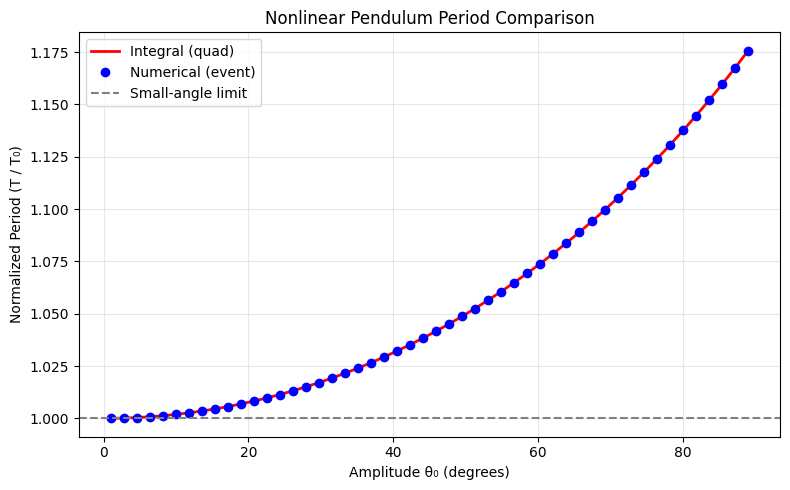

In [9]:
# --- plot and comparisons ---

# Calculate period for a range of initial angles using both methods
theta0_vals = np.linspace(np.deg2rad(1), np.deg2rad(89), 50) # Range of initial angles
T_quad = [nonlinear_period(t0) for t0 in theta0_vals]

T_solveivp = []
for t0 in theta0_vals:
    y0 = [t0, 0.0]
    sol = solve_ivp(pendulum_ode, [0, 20], y0, events=[period_event], rtol=1e-9, atol=1e-9)
    period_times = sol.t_events[0]
    if len(period_times) > 1:
        T_solveivp.append(period_times[1] - period_times[0])
    else:
        T_solveivp.append(np.nan)

T_quad = np.array(T_quad)
T_solveivp = np.array(T_solveivp)
T0 = 2 * np.pi * np.sqrt(L/g) # Small angle period for normalization


plt.figure(figsize=(8,5))
plt.plot(np.rad2deg(theta0_vals), T_quad / T0, 'r-', lw=2, label='Integral (quad)')
plt.plot(np.rad2deg(theta0_vals), T_solveivp / T0, 'bo', label='Numerical (event)')
plt.axhline(1, color='gray', linestyle='--', label='Small-angle limit')

plt.title('Nonlinear Pendulum Period Comparison')
plt.xlabel('Amplitude θ₀ (degrees)')
plt.ylabel('Normalized Period (T / T₀)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()